# Classifying images of everyday objects using a neural network
The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc.<br>

In this notebook, we will:
1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Set up a training pipeline to train a neural network on a GPU
3. Experiment with different network architectures & hyperparameters

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
import pickle

### Exploring the CIFAR10 dataset


In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [4]:
#How many images does the training dataset contain?
dataset_size = len(dataset)
dataset_size

50000

In [4]:
#How many images does the training dataset contain?
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [5]:
#How many output classes does the dataset contain?
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_classes = len(dataset.classes)
num_classes

10

In [7]:
#shape of an image tensor from the dataset
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. matplotlib expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the .permute tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 6
Label (textual): frog


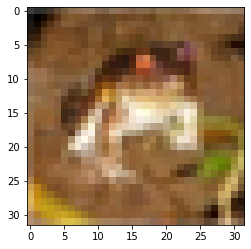

In [8]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
# number of images belonging to each class
all_class={}
for x,y in dataset:
    if classes[y] in all_class.keys():
        all_class[classes[y]]+=1
    else:
        all_class[classes[y]]=1
        
all_class

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

### Preparing the data for training
We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [10]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

Let's use the random_split method to create the training & validation sets



In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders to load the data in batches.



In [12]:
batch_size=128


In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data using the make_grid helper function from Torchvision.



images.shape: torch.Size([128, 3, 32, 32])


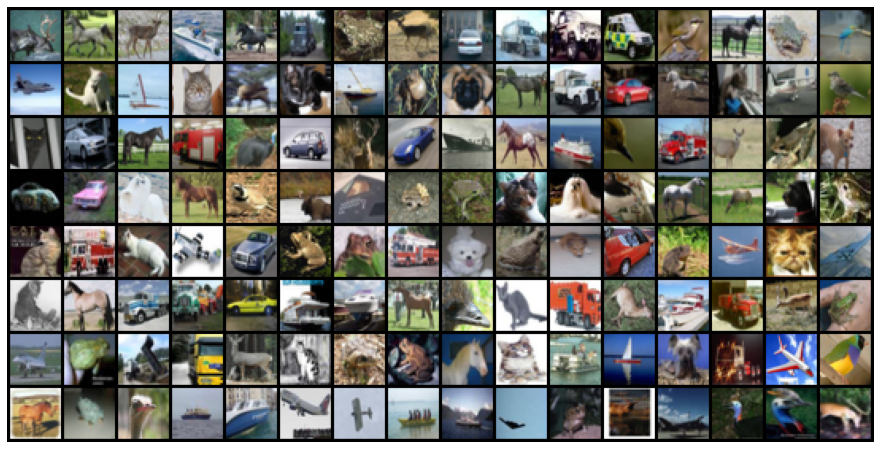

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Base Model class & Training on GPU

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.



In [18]:
torch.cuda.is_available()


False

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cpu')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.



In [22]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.



In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### Training the model
We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:

1. Increase or decrease the number of hidden layers
2. Increase of decrease the size of each hidden layer
3. Try different activation functions
4. Try training for different number of epochs
5. Try different learning rates in every epoch

In [25]:
input_size = 3*32*32
output_size = 10

In [26]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(input_size,1024)
        self.linear2=nn.Linear(1024,512)
        self.linear3=nn.Linear(512,256)
        self.linear4=nn.Linear(256,128)
        self.linear5=nn.Linear(128,64)
        self.linear6=nn.Linear(64,32)
        self.linear7=nn.Linear(32,output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out=self.linear1(out)
        out=F.relu(out)
        out=self.linear2(out)
        out=F.relu(out)
        out=self.linear3(out)
        out=F.relu(out)
        out=self.linear4(out)
        out=F.relu(out)
        out=self.linear5(out)
        out=F.relu(out)
        out=self.linear6(out)
        out=F.relu(out)
        out=self.linear7(out)
        return out

In [27]:
model = to_device(CIFAR10Model(), device)

In [28]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3074228763580322, 'val_acc': 0.09564568102359772}]

In [29]:
history += fit(20, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2976, val_acc: 0.1564
Epoch [1], val_loss: 2.0807, val_acc: 0.1830
Epoch [2], val_loss: 1.9799, val_acc: 0.2577
Epoch [3], val_loss: 2.0124, val_acc: 0.2281
Epoch [4], val_loss: 1.8678, val_acc: 0.2966
Epoch [5], val_loss: 1.7725, val_acc: 0.3448
Epoch [6], val_loss: 1.6947, val_acc: 0.3803
Epoch [7], val_loss: 1.7069, val_acc: 0.3723
Epoch [8], val_loss: 1.7051, val_acc: 0.3750
Epoch [9], val_loss: 1.6507, val_acc: 0.3993
Epoch [10], val_loss: 1.8025, val_acc: 0.3589
Epoch [11], val_loss: 1.6291, val_acc: 0.4157
Epoch [12], val_loss: 1.7373, val_acc: 0.3832
Epoch [13], val_loss: 1.6184, val_acc: 0.4163
Epoch [14], val_loss: 1.9993, val_acc: 0.3291
Epoch [15], val_loss: 1.6793, val_acc: 0.3955
Epoch [16], val_loss: 1.5322, val_acc: 0.4548
Epoch [17], val_loss: 1.5248, val_acc: 0.4589
Epoch [18], val_loss: 1.6009, val_acc: 0.4357
Epoch [19], val_loss: 1.5523, val_acc: 0.4496


In [30]:
history += fit(10, 0.01, model, train_loader, val_loader)


Epoch [0], val_loss: 1.3766, val_acc: 0.5200
Epoch [1], val_loss: 1.3727, val_acc: 0.5167
Epoch [2], val_loss: 1.3771, val_acc: 0.5199
Epoch [3], val_loss: 1.3755, val_acc: 0.5166
Epoch [4], val_loss: 1.3737, val_acc: 0.5183
Epoch [5], val_loss: 1.3808, val_acc: 0.5211
Epoch [6], val_loss: 1.3721, val_acc: 0.5217
Epoch [7], val_loss: 1.3818, val_acc: 0.5168
Epoch [8], val_loss: 1.3904, val_acc: 0.5214
Epoch [9], val_loss: 1.3877, val_acc: 0.5203


In [31]:
history += fit(20, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.3727, val_acc: 0.5264
Epoch [1], val_loss: 1.3730, val_acc: 0.5262
Epoch [2], val_loss: 1.3749, val_acc: 0.5270
Epoch [3], val_loss: 1.3765, val_acc: 0.5274
Epoch [4], val_loss: 1.3755, val_acc: 0.5293
Epoch [5], val_loss: 1.3783, val_acc: 0.5268
Epoch [6], val_loss: 1.3804, val_acc: 0.5297
Epoch [7], val_loss: 1.3808, val_acc: 0.5301
Epoch [8], val_loss: 1.3809, val_acc: 0.5311
Epoch [9], val_loss: 1.3799, val_acc: 0.5313
Epoch [10], val_loss: 1.3820, val_acc: 0.5290
Epoch [11], val_loss: 1.3846, val_acc: 0.5274
Epoch [12], val_loss: 1.3856, val_acc: 0.5294
Epoch [13], val_loss: 1.3872, val_acc: 0.5305
Epoch [14], val_loss: 1.3880, val_acc: 0.5313
Epoch [15], val_loss: 1.3888, val_acc: 0.5286
Epoch [16], val_loss: 1.3867, val_acc: 0.5317
Epoch [17], val_loss: 1.3887, val_acc: 0.5298
Epoch [18], val_loss: 1.3896, val_acc: 0.5358
Epoch [19], val_loss: 1.3918, val_acc: 0.5329


In [32]:
history += fit(10, 0.0001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.3909, val_acc: 0.5329
Epoch [1], val_loss: 1.3910, val_acc: 0.5331
Epoch [2], val_loss: 1.3909, val_acc: 0.5331
Epoch [3], val_loss: 1.3910, val_acc: 0.5325
Epoch [4], val_loss: 1.3913, val_acc: 0.5321
Epoch [5], val_loss: 1.3913, val_acc: 0.5323
Epoch [6], val_loss: 1.3913, val_acc: 0.5323
Epoch [7], val_loss: 1.3916, val_acc: 0.5328
Epoch [8], val_loss: 1.3918, val_acc: 0.5325
Epoch [9], val_loss: 1.3917, val_acc: 0.5329


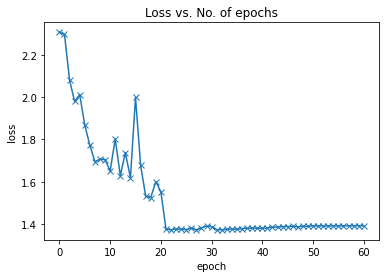

In [33]:
plot_losses(history)


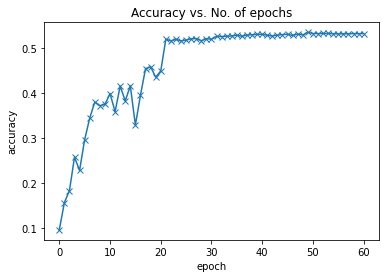

In [34]:
plot_accuracies(history)


Finally, evaluate the model on the test dataset report its final performance.



In [35]:
evaluate(model, test_loader)


{'val_loss': 1.34671950340271, 'val_acc': 0.543164074420929}

In [38]:
# save the model to disk
filename = 'CIFAR10Model.pkl'
pickle.dump(model, open(filename, 'wb'))